In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import matplotlib.pyplot as plt
%pylab inline
import seaborn as sns
from matplotlib import rcParams
rcParams['figure.figsize'] = 20, 10

import Quandl
from n472jw.secrets import quandl_api_key
from n472jw.metrics import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


# I. Get Data

In [4]:
#####[ PARAMS ]#####
ticker = 'ACN'
date_start = pd.datetime(2013, 1, 1)
date_end = pd.datetime(2015, 12, 28)
####################

data = Quandl.get('WIKI/{}'.format(ticker))
data = data[date_start:date_end]
data.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2013-01-02,67.59,69.06,67.55,69.06,4040500,0,1,65.284463,66.704320,65.245827,66.704320,4040500
2013-01-03,68.76,69.36,68.59,68.81,3340700,0,1,66.414553,66.994087,66.250352,66.462848,3340700
2013-01-04,68.92,69.61,68.32,69.19,3145600,0,1,66.569095,67.235559,65.989562,66.829886,3145600
2013-01-07,68.58,68.94,68.35,68.89,2262800,0,1,66.240693,66.588413,66.018538,66.540119,2262800
2013-01-08,68.76,69.46,68.66,69.29,2502800,0,1,66.414553,67.090676,66.317964,66.926474,2502800


# Metrics Visualization

/Users/jhack/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


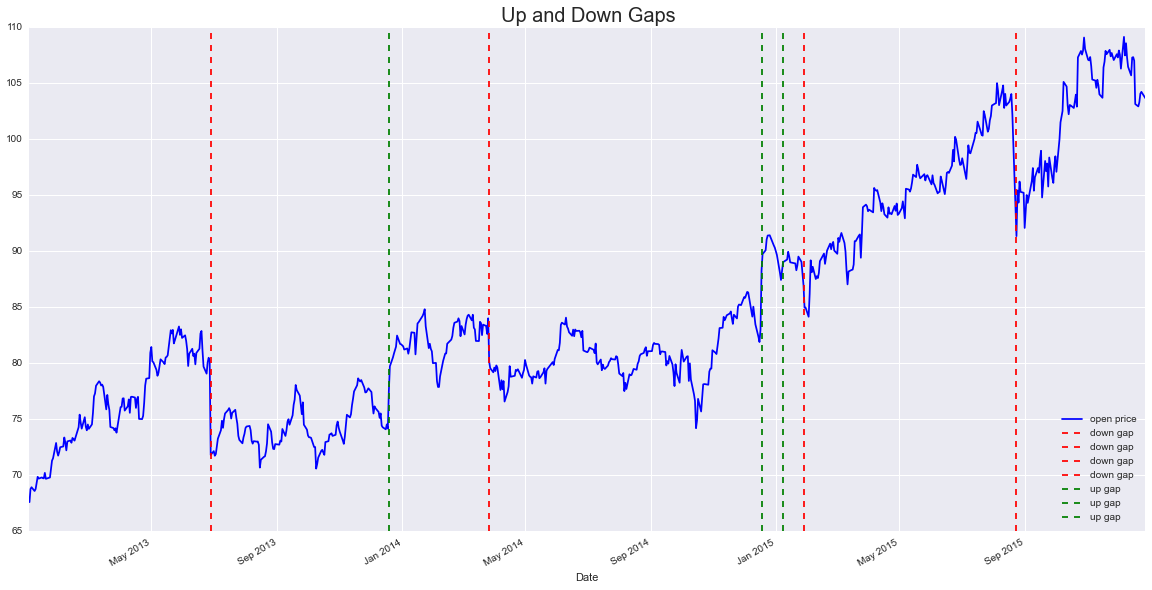

In [5]:
gaps_metric = GapsGetFilled(up_threshold=1, down_threshold=1)
gaps_metric.plot(data)

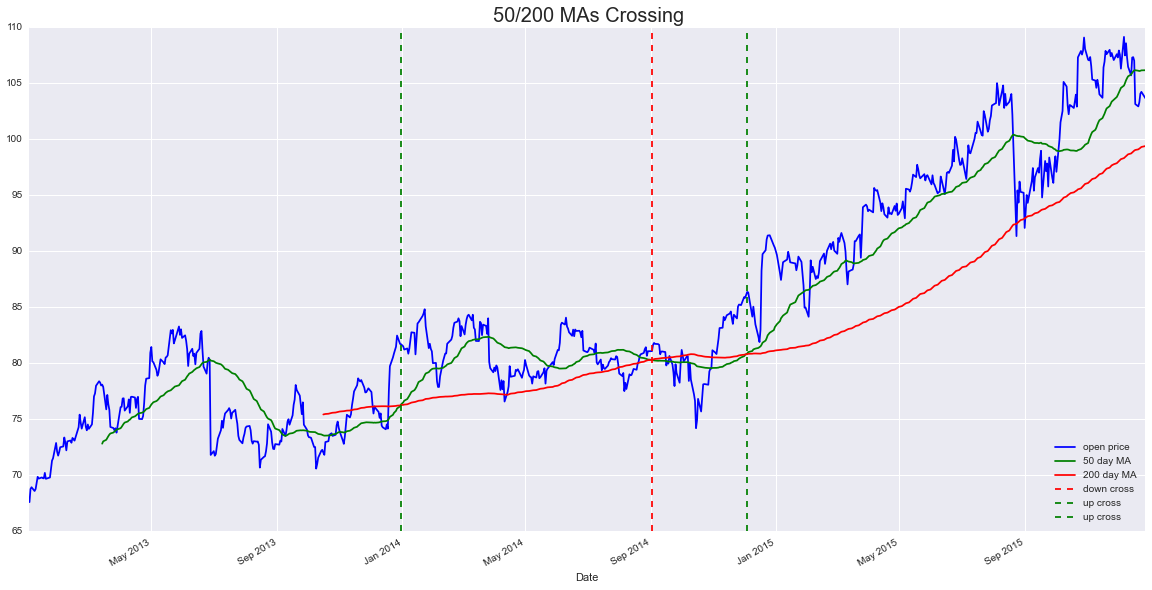

In [7]:
mas_metric = CrossingMovingAverages(ma1=50, ma2=200)
mas_metric.plot(data)